In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
from birdclef.utils import get_spark

spark = get_spark(memory="2g")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/22 20:56:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.parquet(
    "../data/processed/birdclef-2022/birdnet-embeddings-with-neighbors/v1"
)
df.printSchema()
df.show(n=1, vertical=True)

root
 |-- id: integer (nullable = true)
 |-- filename: string (nullable = true)
 |-- start_sec: double (nullable = true)
 |-- end_sec: double (nullable = true)
 |-- confidence: double (nullable = true)
 |-- birdnet_label: string (nullable = true)
 |-- birdnet_common_name: string (nullable = true)
 |-- emb: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- primary_label: string (nullable = true)
 |-- secondary_labels: string (nullable = true)
 |-- type: string (nullable = true)
 |-- neighbors: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- distances: array (nullable = true)
 |    |-- element: double (containsNull = true)



-RECORD 0-----------------------------------
 id                  | 11876                
 filename            | belkin1/XC321817.ogg 
 start_sec           | 15.0                 
 end_sec             | 18.0                 
 confidence          | 0.1058               
 birdnet_label       | rucspa               
 birdnet_common_name | Rufous-crowned Sp... 
 emb                 | [0.54678416, 0.58... 
 primary_label       | belkin1              
 secondary_labels    | []                   
 type                | ['song']             
 neighbors           | [11877, 11876, 11... 
 distances           | [0.0, 0.0, 0.0, 4... 
only showing top 1 row



In [4]:
df.groupby("primary_label").count().sort("count", ascending=False).show(10)

+-------------+-----+
|primary_label|count|
+-------------+-----+
|       normoc|25068|
|       houspa|18173|
|       skylar|12849|
|       norcar|12216|
|       wesmea| 9479|
|       brnowl| 8186|
|      mallar3| 7489|
|       houfin| 6616|
|       commyn| 6524|
|       dunlin| 6069|
+-------------+-----+
only showing top 10 rows



+-------------+------------------+
|primary_label|           matched|
+-------------+------------------+
|       chbsan|0.7258064516129032|
|       hawhaw|0.7171717171717171|
|       comsan|0.7105418719211822|
|       burpar|0.7046263345195729|
|       wetshe|0.6902887139107612|
|       sooshe|0.6861924686192469|
|       puaioh|0.6666666666666666|
|       snogoo|0.6626336522228475|
|       barpet|0.6448598130841121|
|       fragul|0.6323185011709602|
+-------------+------------------+
only showing top 10 rows



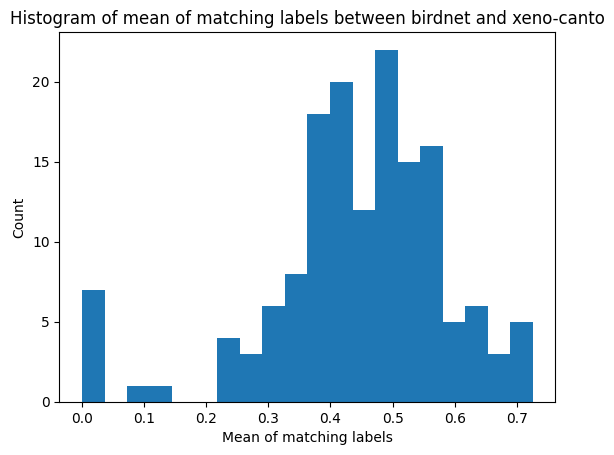

In [5]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

mean_matching = (
    df.select(
        F.expr("birdnet_label = primary_label")
        .cast("integer")
        .alias("matching_labels"),
        "primary_label",
    )
    .groupby("primary_label")
    .agg(F.avg("matching_labels").alias("matched"))
    .orderBy("matched", ascending=False)
)

mean_matching.show(10)

pdf = mean_matching.toPandas()
plt.hist(pdf["matched"], bins=20)
plt.title("Histogram of mean of matching labels between birdnet and xeno-canto")
plt.xlabel("Mean of matching labels")
plt.ylabel("Count")
plt.show()

In [6]:
exploded_neighborhood = df.select(
    "id",
    F.explode(F.arrays_zip("neighbors", "distances")).alias("neighbor"),
).select("id", "neighbor.*")

exploded_neighborhood.show(10)

+-----+---------+-----------------+
|   id|neighbors|        distances|
+-----+---------+-----------------+
|11876|    11877|              0.0|
|11876|    11876|              0.0|
|11876|    11875|              0.0|
|11876|    11883|4.217796325683594|
|11876|    11884|4.217796325683594|
|11876|    11868| 4.36574125289917|
|11876|    11867| 4.36574125289917|
|11876|    11869| 4.36574125289917|
|11876|    11872|5.709606170654297|
|11876|    11874|5.709606170654297|
+-----+---------+-----------------+
only showing top 10 rows



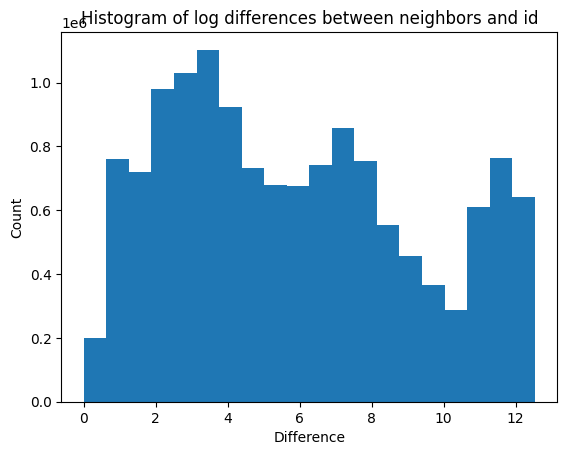

In [7]:
# note that we can take advantage of the fact that ids are sorted by filename
# (including species and file) and time.

diffs = exploded_neighborhood.select(F.expr("log(abs(neighbors - id)+1)").alias("diff"))
pdf = diffs.toPandas()
plt.hist(pdf["diff"], bins=20)
plt.title("Histogram of log differences between neighbors and id")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.show()

We take log distances because otherwise it heavily skews to one side.
It's interesting to see that we parts on the long tail, where neighbors come from some distant cluster.
This means that there are definitely related species (or sounds) in the dataset.

One improvement that we can make is to sort species by projecting all the entries on a single dimension (a line) and to find differences on that line.
Actually lets go ahead and try out that idea.

In [8]:
import numpy as np
import umap

X = np.stack(df.select("emb").toPandas().emb)
reducer = umap.UMAP(n_components=1, verbose=True)
emb = reducer.fit_transform(X)

/home/acmiy/birdclef-2023/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP(n_components=1, verbose=True)
Sun Jan 22 20:57:14 2023 Construct fuzzy simplicial set
Sun Jan 22 20:57:14 2023 Finding Nearest Neighbors
Sun Jan 22 20:57:14 2023 Building RP forest with 31 trees
Sun Jan 22 20:57:20 2023 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	Stopping threshold met -- exiting after 6 iterations
Sun Jan 22 20:57:50 2023 Finished Nearest Neighbor Search
Sun Jan 22 20:57:56 2023 Construct embedding


/home/acmiy/birdclef-2023/venv/lib/python3.7/site-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/acmiy/birdclef-2023/venv/lib/python3.7/site-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
Epochs completed: 100%| ██████████ 200/200 [01:19]


Sun Jan 22 21:13:43 2023 Finished embedding


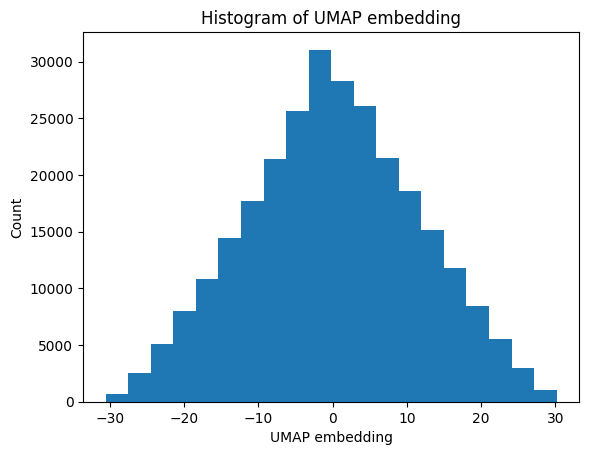

Text(0, 0.5, 'UMAP embedding')

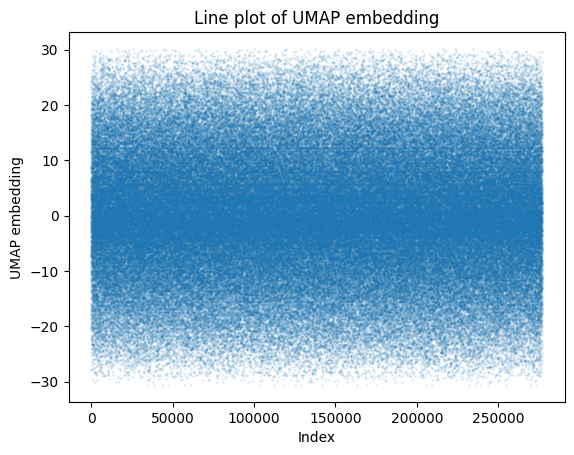

In [9]:
# what does this look like? a histogram?
# a histogram probably has highest density around clusters

plt.hist(emb, bins=20)
plt.title("Histogram of UMAP embedding")
plt.xlabel("UMAP embedding")
plt.ylabel("Count")
plt.show()

# what about a line plot? This will show the difference in ordering between elements.
# I'd expect
plt.scatter(np.arange(len(emb)), emb, s=1, alpha=0.1)
plt.title("Line plot of UMAP embedding")
plt.xlabel("Index")
plt.ylabel("UMAP embedding")

In [10]:
# now create an index that's based on the ordering of the embedding
import pandas as pd

index_df = (
    pd.DataFrame({"line_emb": emb[:, 0], "id": df.select("id").toPandas().id})
    .sort_values("line_emb")
    .reset_index()
    .drop("index", axis=1)
    .reset_index()
    .rename(columns={"index": "index_id"})
)
index_df

,index_id,line_emb,id
0,0,-30.578005,12666
1,1,-30.577869,12667
2,2,-30.577826,12665
3,3,-30.577774,12669
4,4,-30.577766,12670
...,...,...,...
276743,276743,30.153166,76852
276744,276744,30.153221,76851
276745,276745,30.153286,76893
276746,276746,30.153614,76850


In [11]:
mapping = spark.createDataFrame(index_df)
mapping.show(10)

+--------+----------+-----+
|index_id|  line_emb|   id|
+--------+----------+-----+
|       0|-30.578005|12666|
|       1| -30.57787|12667|
|       2|-30.577826|12665|
|       3|-30.577774|12669|
|       4|-30.577766|12670|
|       5|-30.577732|12664|
|       6|-30.577715|12668|
|       7|-30.577703|12661|
|       8| -30.57769|12659|
|       9| -30.57768|12658|
+--------+----------+-----+
only showing top 10 rows



In [12]:
mapped_neighbors = exploded_neighborhood.join(
    mapping.select("id", F.col("index_id").alias("mapped_id")), on="id"
).join(
    mapping.select(
        F.col("id").alias("neighbors"), F.col("index_id").alias("mapped_neighbors")
    ),
    on="neighbors",
)
mapped_neighbors.show()

+---------+------+------------------+---------+----------------+
|neighbors|    id|         distances|mapped_id|mapped_neighbors|
+---------+------+------------------+---------+----------------+
|   160008|160009|               0.0|   265897|           58596|
|   160009|160009|               0.0|   265897|          265897|
|   160002|160009| 3.332265853881836|   265897|           58832|
|   160017|160009|3.3545632362365723|   265897|          265858|
|   160016|160009|3.3545632362365723|   265897|           58695|
|   160000|160009|3.7112810611724854|   265897|           59323|
|   160023|160009| 4.720808506011963|   265897|           58997|
|   159997|160009|5.2726898193359375|   265897|           40277|
|   161471|160009| 7.745424270629883|   265897|           53337|
|   153839|160009| 7.777100086212158|   265897|          155054|
|   153840|160009| 7.777100086212158|   265897|           19933|
|   161984|160009|  7.89493465423584|   265897|           20012|
|   161983|160009|  7.894

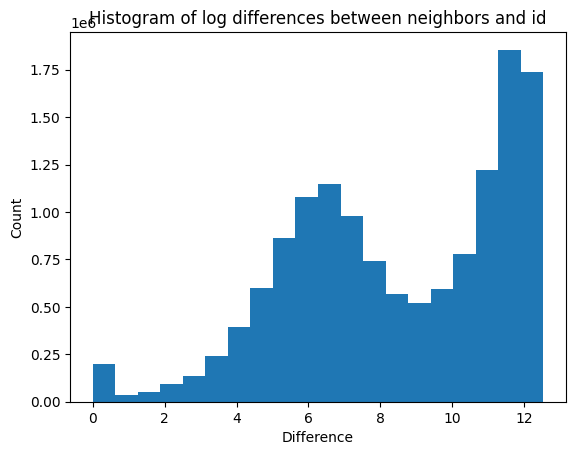

In [13]:
# plot distances again
diffs = mapped_neighbors.select(
    F.expr("log(abs(mapped_neighbors - mapped_id)+1)").alias("diff")
)
pdf = diffs.toPandas()
plt.hist(pdf["diff"], bins=20)
plt.title("Histogram of log differences between neighbors and id")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.show()

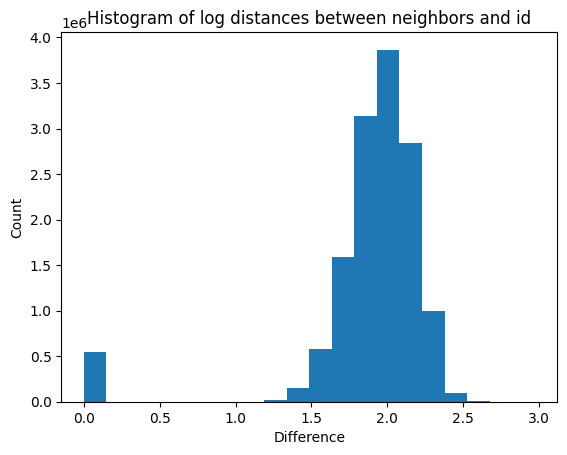

In [14]:
diffs = exploded_neighborhood.select(F.expr("log(distances+1)").alias("diff"))
pdf = diffs.toPandas()
plt.hist(pdf["diff"], bins=20)
plt.title("Histogram of log distances between neighbors and id")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.show()